In [15]:
from datetime import datetime
import math
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import xgboost as xg

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
df = pd.read_csv('baltimore-city-employee-salaries-fy2019.csv')
df.columns= df.columns.str.lower()
print(df.count())

# Заменим пропуски на среднее значение по колонкам gross и hire_dt
# Replacing the gaps with the mean value across the gross and hire_dt columns

gross_mean = df.loc[:, 'gross'].mean()
df['gross'] = df['gross'].replace([0.0, 1.0], gross_mean)
df.loc[:, 'gross'].fillna(gross_mean, inplace=True)
df.loc[:, 'hire_dt'].fillna(datetime(2020, 1, 1), inplace=True)

name         13811
jobtitle     13811
deptid       13811
descr        13811
hire_dt      13807
annual_rt    13811
gross        13158
dtype: int64


In [17]:
# Выясним список всех профессий участвующих в выборке и их средний заработок
# Let's find out the list of all professions participating in the sample and their average earnings

df_jobtitle = df[['jobtitle', 'gross']]
df_jobtitle = df_jobtitle.groupby('jobtitle', as_index=False).mean()
df_jobtitle.describe()

# Видим, что их 1010 уникальных наименований
# We see that there are 1010 unique items


,gross
count,1010.000000
mean,64405.285903
std,28810.104689
min,1461.540000
25%,45836.290833
50%,60914.598636
75%,77901.222500
max,238772.040000


In [18]:
df_jobtitle.sort_values(by=['gross'], inplace=True)
# lowest income is:
print(f"Самая низкая средняя зарплата у специалистов: {df_jobtitle.iloc[0]['jobtitle']}\n она составляет: {df_jobtitle.iloc[0]['gross']:.2f}")
# highest income is:
print(f"Самая высокая средняя зарплата у специалистов: {df_jobtitle.iloc[-1]['jobtitle']}\n она составляет: {df_jobtitle.iloc[-1]['gross']:.2f}")


Самая низкая средняя зарплата у специалистов: Office Assistant
 она составляет: 1461.54
Самая высокая средняя зарплата у специалистов: State's Attorney
 она составляет: 238772.04


array([[<AxesSubplot:title={'center':'gross'}>]], dtype=object)

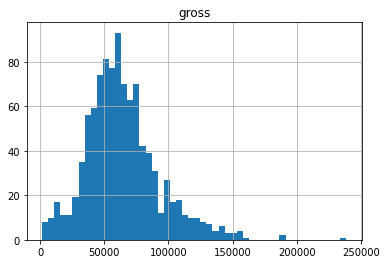

In [19]:
# Гистограмма распределения уровня зарплат по частоте
# Histogram of the distribution of wages by frequency

df_jobtitle.hist(column='gross', bins=50)

In [20]:
# Конвертируем колонку даты приёма на работу в стаж работы (в днях)
# Converting the column of hire_date into work experience (in days)

convert_point = datetime(2020, 1, 1)
df['hire_dt'] = pd.to_datetime(df['hire_dt'])
work_experience = convert_point - df['hire_dt']
df['work_exp'] = work_experience.dt.days
df.head()


,name,jobtitle,deptid,descr,hire_dt,annual_rt,gross,work_exp
0,"Aaron,Kareem D",Utilities Inst Repair I,A50550,DPW-Water & Waste Water (550),2018-08-27,32470.0,25743.94,492
1,"Aaron,Patricia G",Facilities/Office Services II,A03031,OED-Employment Dev (031),1979-10-24,60200.0,57806.13,14679
2,"Abadir,Adam O",Council Technician,A02002,City Council (002),2016-12-12,64823.0,64774.11,1115
3,"Abaku,Aigbolosimuan O",Police Officer,A99094,Police Department (094),2018-04-17,53640.0,59361.55,624
4,"Abbeduto,Mack",Assistant State's Attorney,A29011,States Attorneys Office (011),2017-05-22,68562.0,61693.59,954


In [21]:
# Обработаем категориальный признак deptid
# Можем заметить, что первые 3 символа - это id департамента, последние - уникальный id сотрудника ( он дублируется в колонке descr )
# Оставим только принадлежность к департаменту

# Let`s process categorical attribute deptid
# We can see that the first 3 characters are the department id, the last are the unique id of the employee (it is duplicated in the descr column)
# We will leave the one only belonging to the department

df['deptid'] = df['deptid'].str[:3]
df.head()

,name,jobtitle,deptid,descr,hire_dt,annual_rt,gross,work_exp
0,"Aaron,Kareem D",Utilities Inst Repair I,A50,DPW-Water & Waste Water (550),2018-08-27,32470.0,25743.94,492
1,"Aaron,Patricia G",Facilities/Office Services II,A03,OED-Employment Dev (031),1979-10-24,60200.0,57806.13,14679
2,"Abadir,Adam O",Council Technician,A02,City Council (002),2016-12-12,64823.0,64774.11,1115
3,"Abaku,Aigbolosimuan O",Police Officer,A99,Police Department (094),2018-04-17,53640.0,59361.55,624
4,"Abbeduto,Mack",Assistant State's Attorney,A29,States Attorneys Office (011),2017-05-22,68562.0,61693.59,954


In [22]:
# Поскольку категориальных признаков очень много, рациональнее использовать Label Encoding
# Since there are a lot of categorical features, it is more rational to use Label Encoding

le = LabelEncoder()

df['deptid'] = le.fit_transform(df['deptid'])
df['jobtitle'] = le.fit_transform(df['jobtitle'])

df.head()


,name,jobtitle,deptid,descr,hire_dt,annual_rt,gross,work_exp
0,"Aaron,Kareem D",952,30,DPW-Water & Waste Water (550),2018-08-27,32470.0,25743.94,492
1,"Aaron,Patricia G",353,2,OED-Employment Dev (031),1979-10-24,60200.0,57806.13,14679
2,"Abadir,Adam O",234,1,City Council (002),2016-12-12,64823.0,64774.11,1115
3,"Abaku,Aigbolosimuan O",717,48,Police Department (094),2018-04-17,53640.0,59361.55,624
4,"Abbeduto,Mack",56,17,States Attorneys Office (011),2017-05-22,68562.0,61693.59,954


In [23]:
# Формируем вектор Х и y
# Let`s create vector X and y
X = df[['jobtitle', 'deptid', 'annual_rt', 'work_exp']]
X.reset_index()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

# Разделим вектор на 100000, чтобы получить адекватное значение среднеквадратичной ошибки
# Dividing vector y by 100000 to get an adequate mean square error
y = df.loc[:, 'gross'].map(lambda x: x/100000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,jobtitle,deptid,annual_rt,work_exp
13361,0.407787,0.985454,-0.324811,1.114178
9113,-0.041309,0.503432,0.322711,2.564759
12472,0.992385,-2.113260,-0.954733,-0.238132
10066,0.454245,0.227990,-0.471246,-0.768171
8870,-1.179534,-1.011495,0.162538,-0.214661


### Подберём модель
### Let's start the selection of the model

In [24]:
regressor_l = LinearRegression(n_jobs=-1)
regressor_l.fit(X_train, y_train)

y_pred_test = regressor_l.predict(X_test)

r_sq = regressor_l.score(X_train, y_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print('coefficient of determination:', r_sq)
print('Slope: {:.2f}'.format(regressor_l.coef_[0]))
print('Intercept: {:.2f}'.format(regressor_l.intercept_))
print(f'mse_test: {mse_test:.3f}',)


coefficient of determination: 0.6822029500267149
Slope: 0.02
Intercept: 0.63
mse_test: 0.041


In [25]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
regressor_gb = GradientBoostingRegressor(n_estimators=100)
score_gb = cross_val_score(regressor_gb, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1).mean()
print(f"Score: {score_gb:.3f}")
regressor_gb.fit(X_train,y_train)
y_pred_test_gb = regressor_gb.predict(X_test)
mse_test_gb=mean_squared_error(y_test, y_pred_test_gb)
print(f"mse_test_gb: {mse_test_gb:.3f}")

Score: -0.023
mse_test_gb: 0.023


In [26]:
svm_score = {}
kernel_score = {}
C_range = [10.0 ** i for i in range(-3, 2)]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for C in C_range:
    kernel_score = {}
    for kernel in kernels:
        svm = SVR(C=C, kernel=kernel).fit(X_train, y_train)
        y_pred_test_svm = svm.predict(X_test)
        mse_test_svm=mean_squared_error(y_test, y_pred_test_svm)
        kernel_score[kernel] = round(mse_test_svm,3)
        print(f"mse_test_gb: {mse_test_svm:.3f}")
    svm_score[C] = kernel_score
    print(f"Минимальное значение при С = {C} и ядре: {min(kernel_score.items(), key=lambda x: x[1])}")


mse_test_gb: 0.041
mse_test_gb: 0.069
mse_test_gb: 0.046
mse_test_gb: 0.042
Минимальное значение при С = 0.001 и ядре: ('linear', 0.041)
mse_test_gb: 0.041
mse_test_gb: 0.067
mse_test_gb: 0.035
mse_test_gb: 2.411
Минимальное значение при С = 0.01 и ядре: ('rbf', 0.035)
mse_test_gb: 0.041
mse_test_gb: 0.067
mse_test_gb: 0.033
mse_test_gb: 237.121
Минимальное значение при С = 0.1 и ядре: ('rbf', 0.033)
mse_test_gb: 0.041
mse_test_gb: 0.067
mse_test_gb: 0.033
mse_test_gb: 23248.785
Минимальное значение при С = 1.0 и ядре: ('rbf', 0.033)
mse_test_gb: 0.041
mse_test_gb: 0.067
mse_test_gb: 0.032
mse_test_gb: 2508497.686
Минимальное значение при С = 10.0 и ядре: ('rbf', 0.032)


In [29]:
regressor_sgb = SGDRegressor(random_state=241).fit(X_train, y_train)
y_pred_test_sgb = regressor_sgb.predict(X_test)
mse_test_sgb=mean_squared_error(y_test, y_pred_test_sgb)
rmse_test_sgb=math.sqrt(mse_test_sgb)
print(f"mse_test_sgb: {rmse_test_sgb:.3f}")

mse_test_gb: 0.202


In [33]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10).fit(X_train, y_train)
y_pred_xgbr = xgb_r.predict(X_test)
mse_test_y_pred_xgbr=mean_squared_error(y_test, y_pred_xgbr)
print(f"mse_test_xgb: {mse_test_y_pred_xgbr:.3f}")

mse_test_xgb: 0.023


#### Минимальное значение mse имеет XGBRegressor, для подготовки модели выбираем его.
#### Финальная модель представлена в файле salary-predict.ipynb

#### XGBRegressor has the minimum mse value, we select it to prepare the model.
#### The final model is presented in the salary-pred.ipynb file